In [3]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import matplotlib.pyplot as plt
import os 
import io
from utils.GPU import *
from utils import utils
import tabulate
commons = utils.Commons()
ts_helper = utils.TS_Helper()
ts_helper.model_type = ts_helper.Classification
shap_helper = utils.Shap_Helper()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
#Import train, validation and test sets

training = './data/classification/Tb.brucei/random_split/train_fold_4.csv'
validation = './data/classification/Tb.brucei/random_split/valid_fold_4.csv'
test = './data/classification/Tb.brucei/random_split/test_fold_4.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = 'SMILES'
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
validation_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)

train_dataset.head()

Loaded dataset ./data/classification/Tb.brucei/random_split/train_fold_4.csv with shape: (1051, 3)
Loaded dataset ./data/classification/Tb.brucei/random_split/valid_fold_4.csv with shape: (132, 3)
Loaded dataset ./data/classification/Tb.brucei/random_split/test_fold_4.csv with shape: (131, 3)


,ID,SMILES,Tb.brucei
0,128,CC1(O)C2=CC=CC=C2C2=C1C(OCC(F)(F)F)=NC1=CC=C(B...,1.0
1,821,CC(CNC(=O)NC1=CC=C(F)C=C1)N1CCC(C)CC1,1.0
2,189,CCC(C)C(=O)OC1CCC=C2C=CC(C)C(CCC3CC(O)CC(=O)O3...,1.0
3,983,NC1=NC(NCCCNCCCCCCCCCCCCNCCCNC2=NC(N)=NC(N)=N2...,0.0
4,218,CC1=CC=C(C=C1)S(=O)(=O)NCCCN1C=NC(=N1)[N+]([O-...,1.0


In [5]:
# calculate ECFP (defaut) fingerprints using RDKit
FP_SIZE = 2048  #bit string size
RADIUS = 2 #diameter 4
FEAT = False #used when you consider pharmacophoric features

X_train = commons.assing_fp(train_smiles,FP_SIZE,RADIUS,FEAT)
X_val = commons.assing_fp(val_smiles,FP_SIZE,RADIUS,FEAT)
X_test = commons.assing_fp(test_smiles,FP_SIZE,RADIUS,FEAT)

X_train.shape, X_val.shape, X_test.shape

((1051, 2048), (132, 2048), (131, 2048))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20490     
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

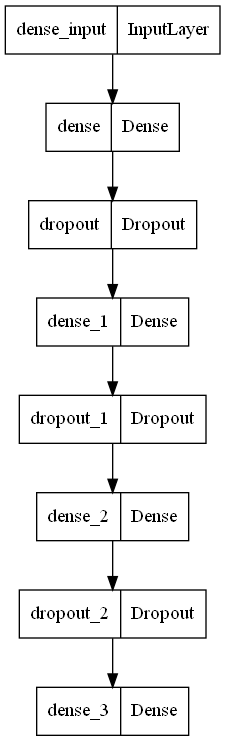

In [6]:
# custom loss function for missing values in input data (i.e. target labels or values)
# parameters for train network

bit_vector = X_train.shape[1]

def create_model():
    return T.keras.models.Sequential([
            T.keras.layers.Dense(10,input_dim=bit_vector, activation='LeakyReLU'),
            T.keras.layers.Dropout(0.5),
            T.keras.layers.Dense(10, activation='LeakyReLU'),
            T.keras.layers.Dropout(0.5),
            T.keras.layers.Dense(10, activation='LeakyReLU'),
            T.keras.layers.Dropout(0.3),
            T.keras.layers.Dense(NUM_TASKS, activation='sigmoid'),
            ])



optimizer = RMSprop(0.1)
lr_metric = ts_helper.get_lr_metric(optimizer)

model = create_model()
model.compile(loss = ts_helper.classification_loss(ts_helper.BinaryCrossentropy), metrics = [lr_metric])    
model.summary()
T.keras.utils.plot_model(model)

In [7]:
# Early stopping parameters

callbacks_list = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000001, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="./models/TM-FNN_classification_model.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1)]


# parameters for train network

epochs=2000
batch_size=10


history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=(callbacks_list))

Epoch 1/2000
 96/106 [==========================>...] - ETA: 0s - loss: 0.6879 - lr: 0.1000
Epoch 1: val_loss improved from inf to 0.66734, saving model to ./models\TM-FNN_classification_model.hdf5
106/106 [==============================] - 1s 3ms/step - loss: 0.6864 - lr: 0.0010 - val_loss: 0.6673 - val_lr: 0.1000
Epoch 2/2000
 78/106 [=====================>........] - ETA: 0s - loss: 0.6522 - lr: 0.1000
Epoch 2: val_loss improved from 0.66734 to 0.61998, saving model to ./models\TM-FNN_classification_model.hdf5
106/106 [==============================] - 0s 2ms/step - loss: 0.6471 - lr: 0.0010 - val_loss: 0.6200 - val_lr: 0.1000
Epoch 3/2000
 84/106 [======================>.......] - ETA: 0s - loss: 0.5952 - lr: 0.1000
Epoch 3: val_loss improved from 0.61998 to 0.57682, saving model to ./models\TM-FNN_classification_model.hdf5
106/106 [==============================] - 0s 2ms/step - loss: 0.5972 - lr: 0.0010 - val_loss: 0.5768 - val_lr: 0.1000
Epoch 4/2000
104/106 [===================

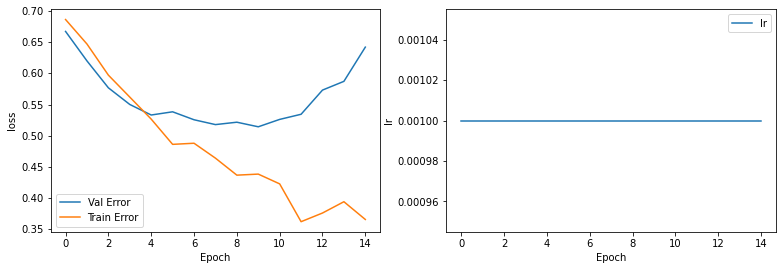

In [8]:
#Plot model history

ts_helper.plot_history(history)

Metric for a Classification Model
33/33 [==============================] - 0s 661us/step
      pred    y
0      1.0  1.0
1      1.0  1.0
2      1.0  1.0
3      0.0  0.0
4      1.0  1.0
...    ...  ...
1046   1.0  1.0
1047   1.0  1.0
1048   0.0  0.0
1049   0.0  0.0
1050   1.0  0.0

[1051 rows x 2 columns]
5/5 [==============================] - 0s 1000us/step
     pred    y
0     1.0  0.0
1     1.0  1.0
2     0.0  0.0
3     0.0  1.0
4     0.0  0.0
..    ...  ...
127   1.0  1.0
128   1.0  1.0
129   0.0  1.0
130   0.0  0.0
131   1.0  1.0

[132 rows x 2 columns]
5/5 [==============================] - 0s 1ms/step
     pred    y
0     1.0  1.0
1     0.0  0.0
2     1.0  0.0
3     1.0  1.0
4     0.0  1.0
..    ...  ...
126   1.0  1.0
127   0.0  1.0
128   0.0  0.0
129   1.0  0.0
130   1.0  0.0

[131 rows x 2 columns]
Confusion matrix: [[500  55]
 [ 55 441]]
Confusion matrix: [[52 19]
 [15 46]]
Confusion matrix: [[45 17]
 [18 51]]
For Training in task 0 
 Statistic        Value
-----------  -----

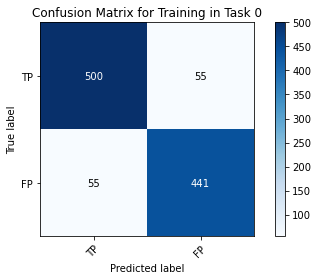

[[52 19]
 [15 46]]


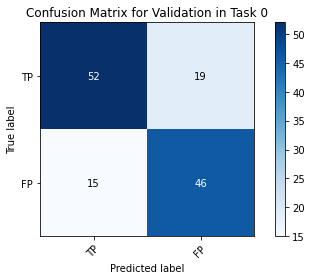

[[45 17]
 [18 51]]


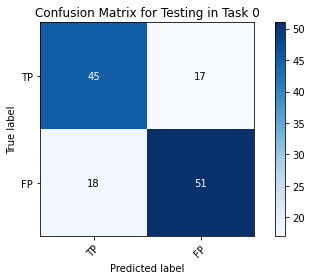

In [9]:
#Statistical characteristics of tasks

THRESHOLD = 0.5
ts_helper.get_modelStats(model, X_train, y_train, X_test, y_test,X_val, y_val,NUM_TASKS,THRESHOLD)